In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns

In [44]:
class Args:
    def __init__(self):
        self.dataset = 'gdp'
        self.gpu = 0
        self.train_bias_f = False
        self.train_bias_y = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = False
        self.re_bias_f = False
        self.num_bins = 0
        self.knn = 100
        self.run_label = 1 #0
        self.model = 'linear' #'small'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.log_root = './runs/unbiased'
        # self.log_root = 'log3'


In [49]:
num_rep = 3
# num_runs = list(range(24)) + list(range(40, 40+24))
num_runs = list(range(0, 10))
fps = np.zeros((8, len(num_runs) * num_rep, 8))
fns = np.zeros((8, len(num_runs) * num_rep, 8))
objectives = np.zeros((8, len(num_runs) * num_rep, 5))
for objective in range(8):
    args = Args()
    if objective % 2 == 1:
        args.train_bias_f = True
    if (objective // 2) % 2 == 1:
        args.train_bias_y = True
    if objective // 4 == 1:
        args.train_calib = True
    
    for run_i, run_label in enumerate(num_runs):
        args.run_label = run_label
        args.name = '%s_knn/new_model=%s-%r-%r-%r-%r-bs=%d-run=%d' % \
                                    (args.dataset, args.model, args.train_bias_y, args.train_bias_f, args.train_cons,
                                     args.train_calib, args.batch_size, run_label)
        log_dir = os.path.join(args.log_root, args.name)
        reader = open(os.path.join(log_dir, 'results.txt'))
#         print(os.path.join(log_dir, 'results.txt'))
#         for epoch in range(2000):
        for epoch in range(499):
            reader.readline()
        line = reader.readline().split()
#         print(line)
        for rep in range(num_rep):  
#             import pdb
#             pdb.set_trace()
#             print(os.path.join(log_dir, 'results.txt'))
            objectives[objective, run_i*num_rep+rep] = np.array([float(line[i]) for i in range(5)])
            fns[objective, run_i*num_rep+rep] = np.array([float(line[i]) for i in range(5, 13)])
            fps[objective, run_i*num_rep+rep] = np.array([float(line[i]) for i in range(13, 21)])
            for epoch in range(200):
                reader.readline()
            

./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=0/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=1/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=2/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=3/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=4/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=5/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=6/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=7/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=8/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-False-False-False-bs=1024-run=9/results.txt
./runs/unbiased/gdp_knn/new_model=linear-False-True-False-False-bs=1024-run=0/results.txt


In [46]:
from sklearn.isotonic import IsotonicRegression

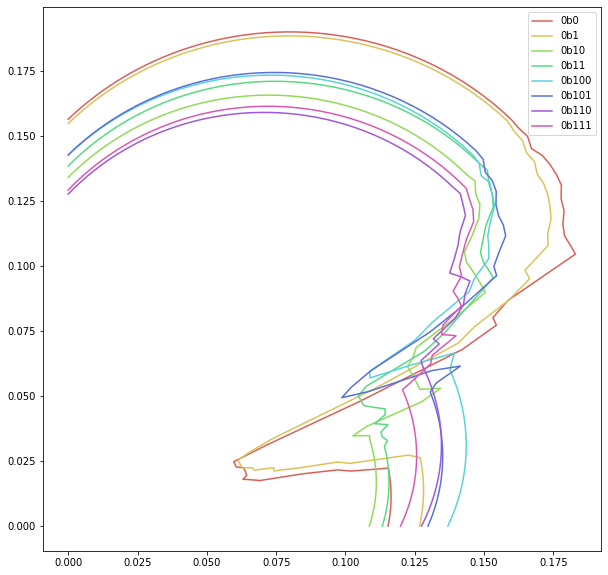

In [50]:
plt.figure(figsize=(10, 10))
palette = sns.color_palette('hls', 8)
for i in range(8):
    # plt.scatter(fns[i].flatten(), fps[i].flatten(), alpha=0.5, color=palette[i] , label=names[i])
    
    # iso_reg = IsotonicRegression(increasing=False).fit(fns[i].flatten(), fps[i].flatten())
    # new_fn = np.linspace(np.min(fns[i]), np.max(fns[i]), 1000)
    # plt.plot(new_fn, iso_reg.predict(new_fn), color=palette[i], linestyle='-.')
    
    # iso_reg = IsotonicRegression(increasing=False).fit(fps[i].flatten(), fns[i].flatten())
    # new_fp = np.linspace(np.min(fps[i]), np.max(fps[i]), 1000)
    # plt.plot(iso_reg.predict(new_fp), new_fp, color=palette[i], linestyle=':')
    
    resolution = 100
    fnfp = np.stack([fns[i].flatten(), fps[i].flatten()], axis=-1)
    fnfp_norm = fnfp / np.linalg.norm(fnfp, 2, axis=-1, keepdims=True)
    center = np.stack([np.linspace(0.0, 1.0, 100), np.linspace(1.0, 0.0, 100)], axis=-1)
    center /= np.linalg.norm(center, 2, axis=-1, keepdims=True)
    
    avg = np.zeros(resolution)
    for k in range(resolution):
        cos_dis = np.argsort(np.sum(fnfp_norm * center[k:k+1], axis=-1))
        avg[k] = np.mean(np.sum(fnfp * center[k:k+1], axis=-1)[cos_dis[-40:]])
    
    vals = center * np.reshape(avg, (-1, 1))
    plt.plot(vals[:, 0], vals[:, 1], color=palette[i], label=bin(i))
    
    
plt.legend()
plt.savefig('result.png')
plt.show()

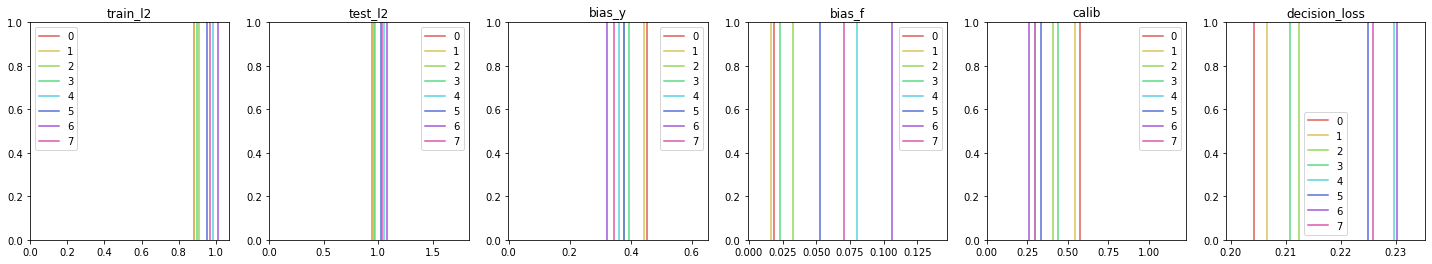

In [51]:
names = ['train_l2', 'test_l2', 'bias_y', 'bias_f', 'calib']
plt.figure(figsize=(25, 4))
for item in range(5):
    plt.subplot(1, 6, item+1)
    for i in range(8):
        plt.axvline(objectives[i, :, item].mean(), c=palette[i], label=i)
    plt.xlim([-0.001, objectives[:, :, item].max()+0.01])
    plt.legend()
    plt.title(names[item])
    
plt.subplot(1, 6, 6)
for i in range(8):
    plt.axvline(fps[i, :, :].mean() + fns[i, :, :].mean(), c=palette[i], label=i)
    plt.legend()
    
    x_range = [(fps + fns).mean(axis=(1, 2)).min(), (fps+fns).mean(axis=(1, 2)).max()]
    plt.xlim(x_range[0] - (x_range[1]-x_range[0]) * 0.2, x_range[1] + (x_range[1]-x_range[0]) * 0.2)
    plt.title('decision_loss')
plt.savefig('plots/decision_%s' % args.model)
plt.show()